In [43]:
# financial data analysis with arhmm

In [44]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [45]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd
import warnings

In [46]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

In [47]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]
open_diff = np.diff(np.log(data['Open']))[1:]

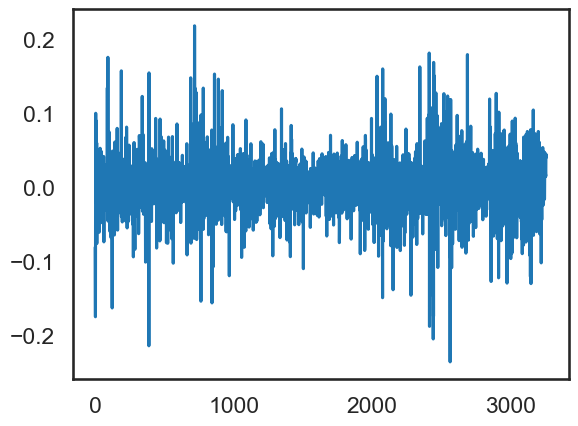

In [48]:
plt.plot(close_diff)

## fitting a model

In [49]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 4
emission_dim = 2
num_lags = 1


open_diff = (open_diff - np.mean(open_diff))/np.std(open_diff)
close_diff = (close_diff - np.mean(close_diff))/np.std(close_diff)
print(open_diff.shape)
emissions = np.vstack((open_diff, close_diff))
print(emissions.shape)

emissions = jnp.array(emissions.T)
print(emissions.shape)

time_bins = len(emissions)

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

(3258,)
(2, 3258)
(3258, 2)


/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the log-likelihood

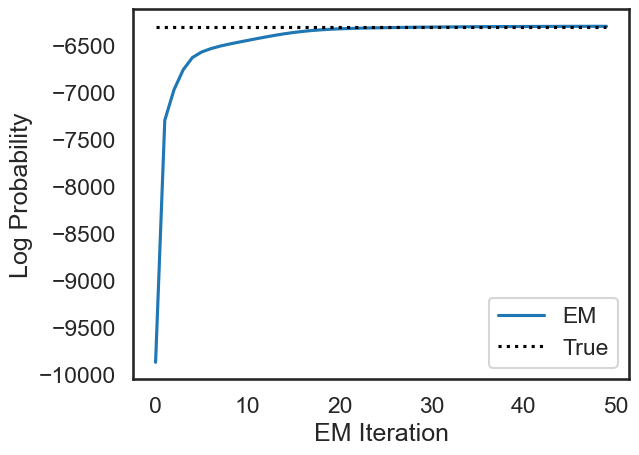

In [50]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [51]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.071509  , 0.78096855, 0.07142862, 0.07609386], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.05802174, 0.02883111, 0.19260643, 0.72054076],
       [0.21168745, 0.71259385, 0.00402756, 0.07169124],
       [0.00317843, 0.01877306, 0.8567831 , 0.12126549],
       [0.70687044, 0.05275708, 0.0196177 , 0.22075479]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.4445616 ,  0.67179644],
        [-0.09565424,  0.06911632]],

       [[-0.3792528 ,  0.70139277],
        [-0.01870297,  0.00634528]],

       [[-0.05360647,  0.85135454],
        [ 0.00246995,  0.03258665]],

       [[-0.02392349,  0.9582116 ],
        [ 0.07890416, -0.1145143 ]]], dtype=float32), biases=Array([[ 0.09107724,  0.03656394],
       [-0.03073205,  0.08884218],
       [-0.00227475,  0.01009006],
       [-0.09287082, -0.07909967]], dtype=float32), covs=Array([[[0.18200512, 0.07669746],
        [0.07669746, 0.53163457]],

      

# find most likely states

In [52]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

## plot of most likely states

Text(0, 0.5, 'Close Values')

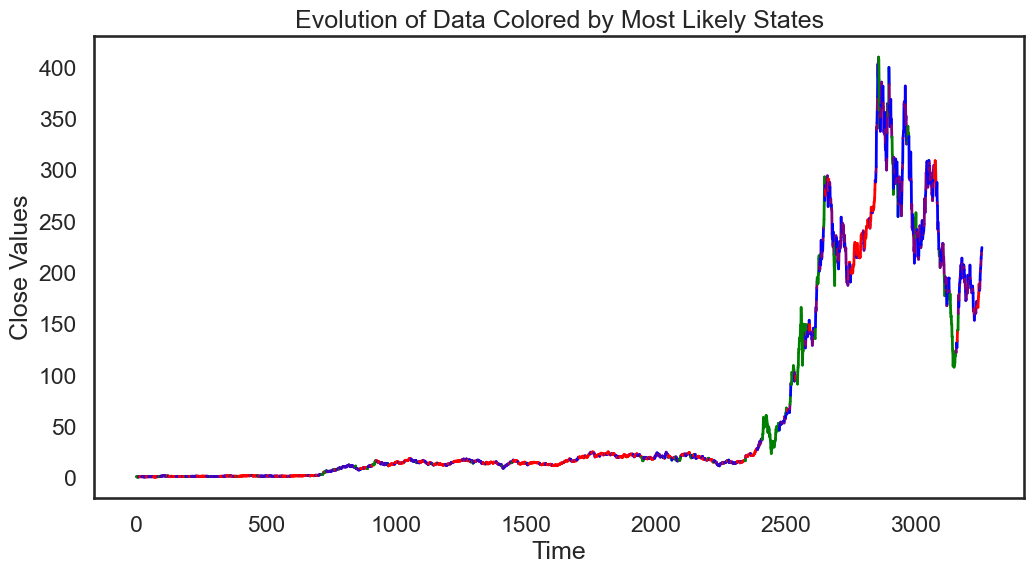

In [53]:
d = data['Close'][1:].to_numpy()

colors = ['blue', 'green', 'red', 'purple']
state_colors = [colors[state] for state in most_likely_states]

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(1, len(d)-2):
    ax.plot([i-1, i], [d[i-1], d[i]], color=state_colors[i], linewidth=2)

ax.set_title('Evolution of Data Colored by Most Likely States')
ax.set_xlabel('Time')
ax.set_ylabel('Close Values')

## plot of distribution of hidden states

Text(0.5, 0, 'time')

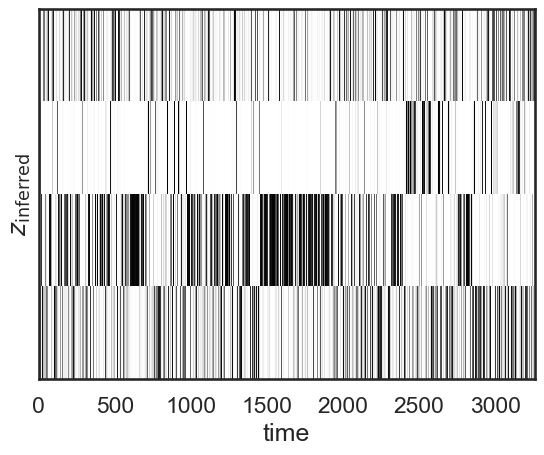

In [54]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

# sample new data and plot them

(3258, 2)


Text(0, 0.5, 'Emissions')

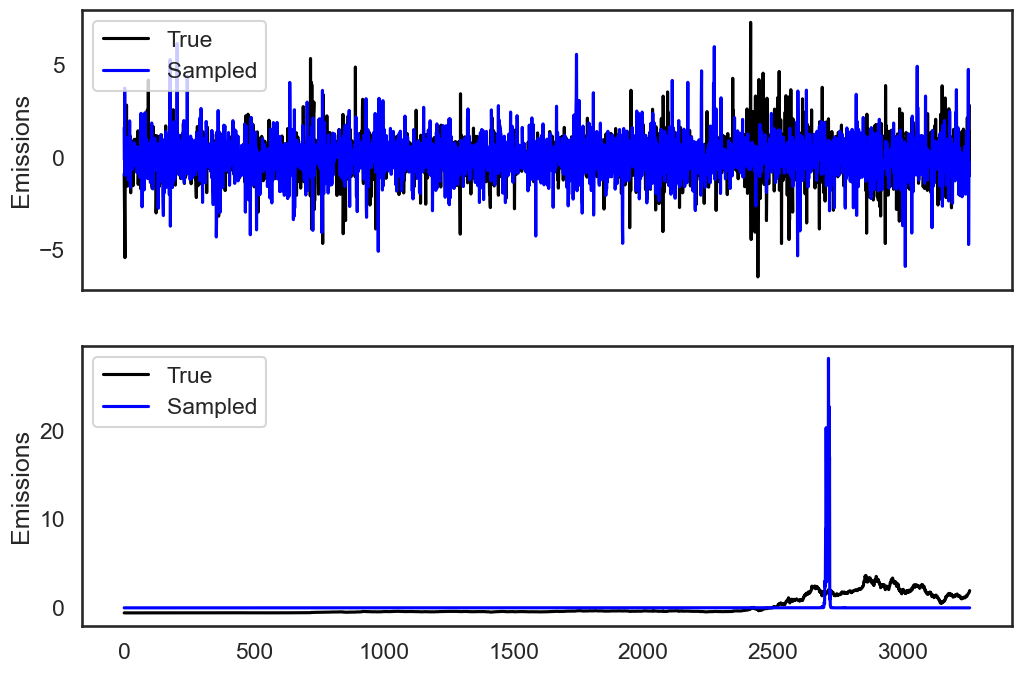

In [55]:
# can add here also the first obs of the real data
# prev_emissions = data['Close'].iloc[1]
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins, np.array(emissions[0:num_lags]).reshape(num_lags, emission_dim))

sampled_emissions_open = sampled_emissions[:,0]
sampled_emissions_close = sampled_emissions[:,1]

print(sampled_emissions.shape)

initial_value = data['Close'].iloc[1]
recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions_close.reshape(-1))))
recovered_series = np.exp(recovered_log)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions[:,0], color="black", label="True")
ax[0].plot(sampled_emissions_close, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")


d = data['Close'][1:].to_numpy()
d = (d-np.mean(d))/np.std(d)

recovered_series = (recovered_series - np.mean(recovered_series)) / np.std(recovered_series)

ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

In [56]:
initial_value = 0
start = [1,2,3,1,4,5,3,7,4]
converted = np.diff(np.log(start))
print(converted)
recovered_log = np.cumsum(np.concatenate(([np.log(start[0])], converted)))
recovered_series = np.exp(recovered_log)
print(recovered_series)

[ 0.69314718  0.40546511 -1.09861229  1.38629436  0.22314355 -0.51082562
  0.84729786 -0.55961579]
[1. 2. 3. 1. 4. 5. 3. 7. 4.]


Text(0.5, 0, 'time')

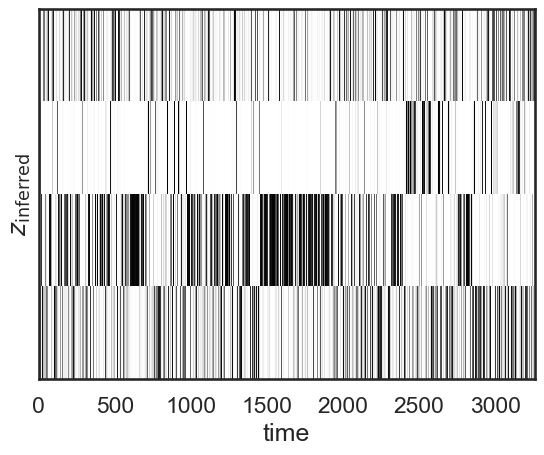

In [57]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

## prediction

In [58]:
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 4
emission_dim = 1
num_lags = 1
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
"""
trying to suppress the stdout of the fit function but with no result
import contextlib
import io

def suppress_output(func):
    def wrapper(*args,**kwargs):
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            return func(*args, **kwargs)
        return wrapper

@suppress_output
"""  

def pred_smoothed_probs(emission, obs, arhmm):
    """
    Predict the next point using a sequence of observations.
    weight the prediction on the last state distribution
    remember the the emissions are passed as log(return)
    """
    params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
    inputs = arhmm.compute_inputs(emissions)

    # Fit with EM
    fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)
    posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
    most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)
    most_likely_state = most_likely_states[-1]

    transition_matrix = np.array(fitted_params[1]).reshape(num_states, num_states)
    last_state_probs = transition_matrix[most_likely_state]
    last_state_probs = last_state_probs.reshape(num_states, 1)
    
    weight = np.array(fitted_params[2][0]).reshape(-1, 1)
    bias = np.array(fitted_params[2][1]).reshape(-1, 1)
    
    # do i compute the weighted mean before or after doing the exponential??    
    # we are doing the weighted mean before the exponential because the model predicts the log return

    pred_log_return = emission[-1] * weight + bias
    pred_log_return = np.dot(pred_log_return.T, last_state_probs)
    pred_return = np.exp(pred_log_return)
    pred = obs * pred_return


    return pred

In [59]:
print(data['Close'][200])
d = data['Close'][:201].to_numpy()
print(d[-1])
print(data['Close'][201])
pred_smoothed_probs(emissions[:200], data['Close'][200], arhmm=arhmm)

1.6619999408721924
1.6619999408721924
1.6759999990463257


/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (1, 1), (3258, 2).

In [ ]:
warnings.simplefilter("ignore")

predictions = []
start = 1500
end = 2000
for i in range(start, end, 1):
    print(i)
    predictions.append(pred_smoothed_probs(emissions[:i+1], data['Close'][i]))

1500


1501


1502


1503


1504


1505


1506


1507


1508


1509


KeyboardInterrupt: 

500 500
(500, 1) (500, 1)


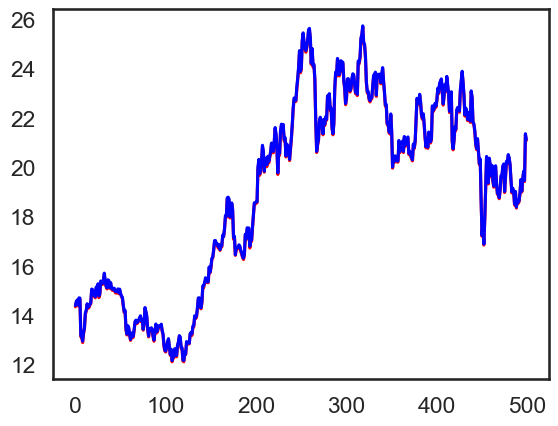

In [ ]:
d = data['Close'][start:end].to_numpy()
d = d.reshape(end - start,-1)
plt.plot(d, color = 'red')
predictions = np.array(predictions).reshape(-1, 1)
plt.plot(predictions, color='blue')
print(len(d), len(predictions))
print(d.shape, predictions.shape)

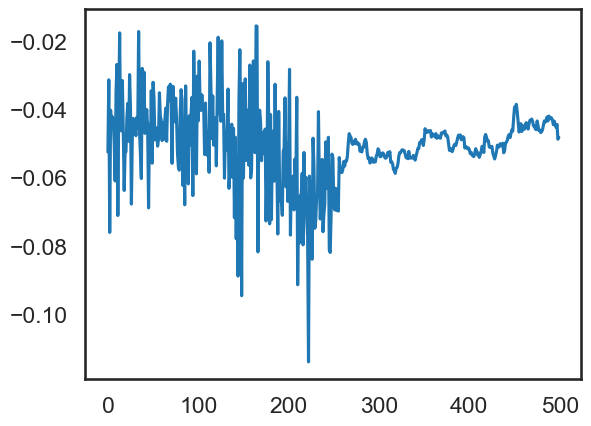

In [ ]:
plt.plot(d-predictions)

In [ ]:
# rss of predictions on log return 
print(np.sum(np.square(d-predictions))/len(d))

0.0026708799569841878
